In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime

c:\Users\Woon\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
text_input = input("Type in the Ticker: ")
print("You entered:", text_input)

You entered: xom


In [ ]:
spy_ohlc_df = yf.download('SPY', start=datetime.date.today() - datetime.timedelta(days=1095), end=datetime.date.today())
df=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


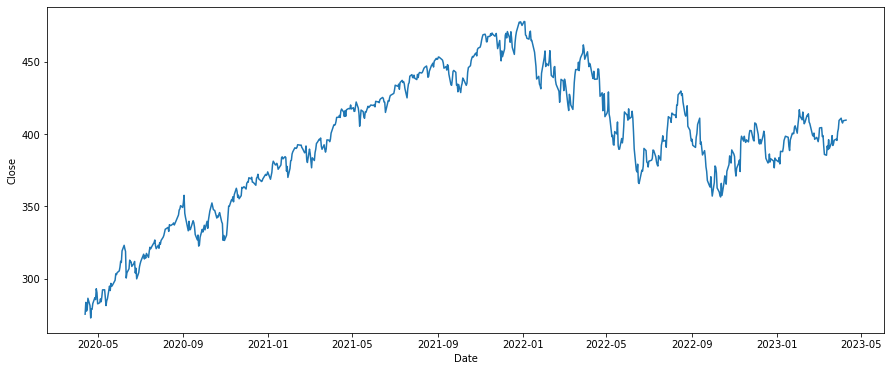

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15,6)
sns.lineplot(x = 'Date', y = 'Close', data = df)
plt.show()

In [ ]:
# Load SPY price data
spy_data = df
spy_data = df[['Date', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=3)

# Make predictions for future dates
forecast = model.predict(future_dates)

22:22:05 - cmdstanpy - INFO - Chain [1] start processing
22:22:05 - cmdstanpy - INFO - Chain [1] done processing


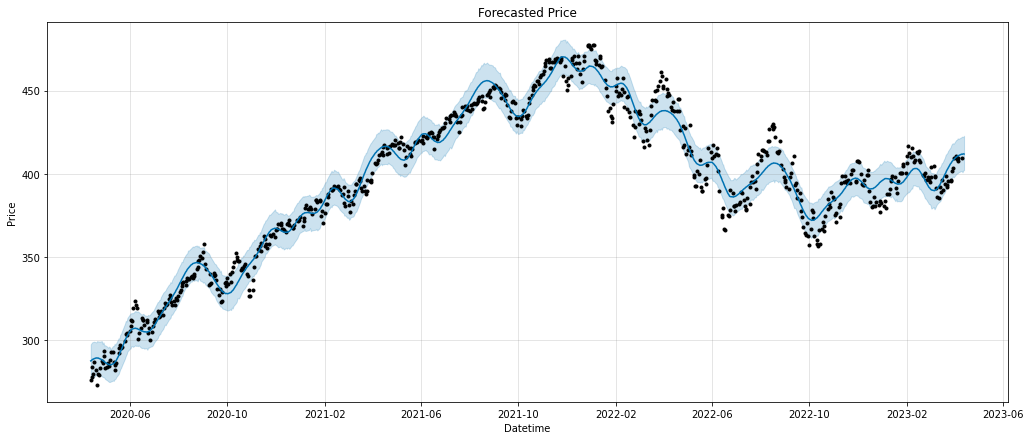

In [ ]:
fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
fig.set_size_inches(15,6)
plt.title('Forecasted Price')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.show()

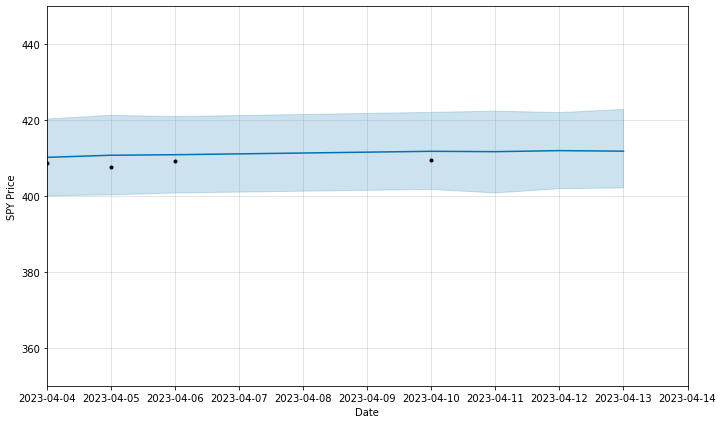

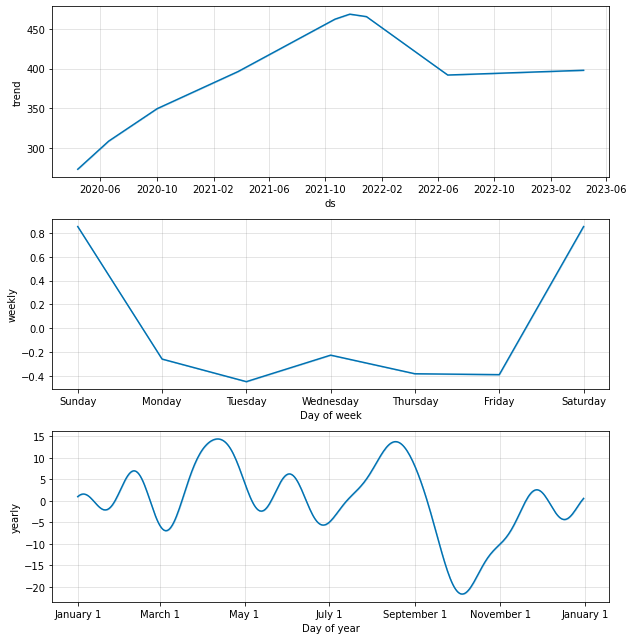

In [ ]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(datetime.date.today() - datetime.timedelta(days=7), datetime.date.today() + datetime.timedelta(days=3))
plt.ylim(350,450)

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()

In [3]:
spy_ohlc_df = yf.download(text_input, start=datetime.date.today() - datetime.timedelta(days=7), end=datetime.date.today(), interval='1m')
df1=spy_ohlc_df.reset_index()

[*********************100%***********************]  1 of 1 completed


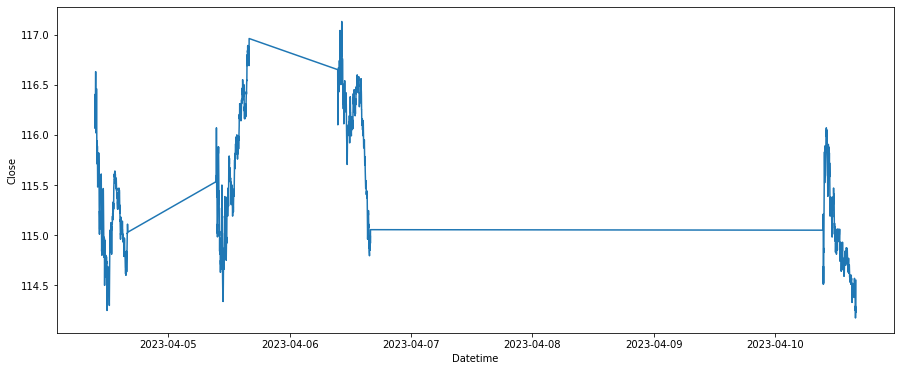

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(15,6)
sns.lineplot(x = 'Datetime', y = 'Close', data = df1)
plt.show()

In [5]:
# #df1.set_index('Datetime', inplace=True)
# forecast_data_total = df1.resample('T')['Close'].sum()
# next_minute = forecast_data_total.index[-1] + pd.Timedelta(minutes=1)
# next_minutes = pd.date_range(next_minute, periods=1440, freq='T')

In [6]:
# Load SPY price data
spy_data = df1
spy_data = df1[['Datetime', 'Close']]
spy_data.columns = ['ds', 'y']

# Initialize Prophet model
model = Prophet()

# Fit the model on SPY data
model.fit(spy_data)

# Create future dates for forecasting
future_dates = model.make_future_dataframe(periods=2880, freq='T')

# Make predictions for future dates
forecast = model.predict(future_dates)


22:22:00 - cmdstanpy - INFO - Chain [1] start processing
22:22:02 - cmdstanpy - INFO - Chain [1] done processing


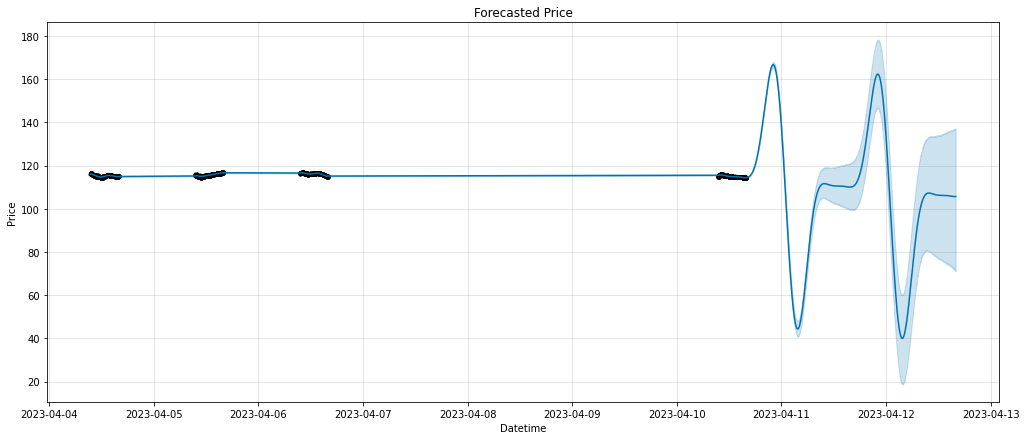

In [7]:
fig = model.plot(forecast, xlabel='Date', ylabel='SPY Price')
fig.set_size_inches(15,6)
plt.title('Forecasted Price')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.show()

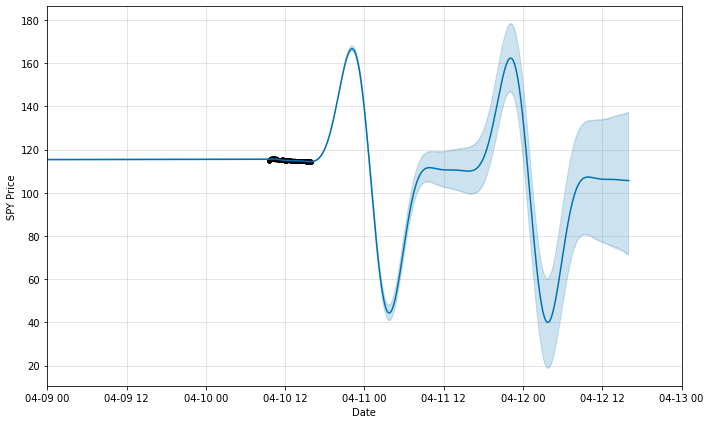

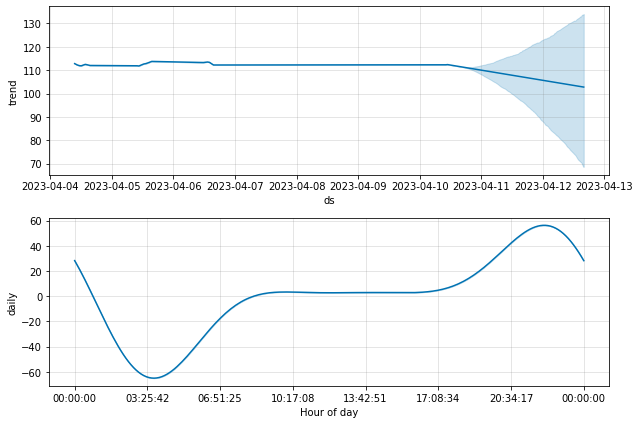

In [8]:
# Plot the forecasted data
model.plot(forecast, xlabel='Date', ylabel='SPY Price')
plt.xlim(datetime.date.today() - datetime.timedelta(days=2), datetime.date.today() + datetime.timedelta(days=2))

# Plot the forecasted trend and seasonality components
fig = model.plot_components(forecast)
plt.show()